In [1]:
import dataloader
import pandas as pd
import numpy as np
import math
import seaborn as sns
sid = '08db4255286f'

In [2]:
data = dataloader.load_sid(sid)

In [8]:
data.sample(5)

,series_id,step,timestamp,anglez,enmo,activity
387642,08db4255286f,387642,2018-11-28 00:23:30+00:00,-8.0271,0.1275,Waking
280684,08db4255286f,280684,2018-11-21 19:50:20+00:00,-31.0313,0.1042,Waking
104122,08db4255286f,104122,2018-11-11 14:36:50+00:00,-17.7477,0.0086,Waking
151583,08db4255286f,151583,2018-11-14 08:31:55+00:00,-62.7159,0.0008,Sleeping
162230,08db4255286f,162230,2018-11-14 23:19:10+00:00,-6.5920,0.0003,Waking


In [9]:
print(f'Total entries:    {len(data)}')
print(f"Waking entries:   {len(data.loc[data['activity']=='Waking'])}")
print(f"Sleeping entries: {len(data.loc[data['activity']=='Sleeping'])}")

Total entries:    440280
Waking entries:   315372
Sleeping entries: 124908


In [11]:
data['hour'] = [i.hour for i in data['timestamp']]
data.sample(5)

,series_id,step,timestamp,anglez,enmo,activity,hour
200825,08db4255286f,200825,2018-11-17 04:55:25+00:00,-5.674000,0.0625,Waking,4
130118,08db4255286f,130118,2018-11-13 02:43:10+00:00,-36.428299,0.1723,Sleeping,2
437121,08db4255286f,437121,2018-11-30 21:06:45+00:00,-17.636999,0.0047,Waking,21
225671,08db4255286f,225671,2018-11-18 15:25:55+00:00,-2.825900,0.0220,Sleeping,15
390200,08db4255286f,390200,2018-11-28 03:56:40+00:00,-6.418500,0.1391,Waking,3


In [75]:
def windows(data, col, buffer=2):
    df2 = dict()
    for i in range(-buffer, buffer+1):
        df2[f'{i}'] = data[col][max(0,i):len(data)+i]
        df2[f'{i}'].index -= i
                # series = data[col].iloc[max(0,i):len(data)+i].copy()
                # series.index -= i
        # df2[f'{i}'].iloc[max(0,i):len(data)+i] = series
    df = pd.DataFrame(df2)
    return df

In [80]:
windows(data, 'enmo', 4)

,-4,-3,-2,-1,0,1,2,3,4
0,NaN,NaN,NaN,NaN,0.0447,0.0443,0.0483,0.0680,0.0768
1,NaN,NaN,NaN,0.0447,0.0443,0.0483,0.0680,0.0768,0.0511
2,NaN,NaN,0.0447,0.0443,0.0483,0.0680,0.0768,0.0511,0.1073
3,NaN,0.0447,0.0443,0.0483,0.0680,0.0768,0.0511,0.1073,0.0649
4,0.0447,0.0443,0.0483,0.0680,0.0768,0.0511,0.1073,0.0649,0.0485
...,...,...,...,...,...,...,...,...,...
440275,0.0010,0.0041,0.0008,0.0019,0.0024,0.0013,0.0021,0.0127,0.0011
440276,0.0041,0.0008,0.0019,0.0024,0.0013,0.0021,0.0127,0.0011,NaN
440277,0.0008,0.0019,0.0024,0.0013,0.0021,0.0127,0.0011,NaN,NaN
440278,0.0019,0.0024,0.0013,0.0021,0.0127,0.0011,NaN,NaN,NaN


In [81]:
# 10min -> 10 * 12steps
padding = 120
angle_window = windows(data, 'anglez', padding)
enmo_window  = windows(data, 'enmo', padding)

In [84]:
angle_window.shape, enmo_window.shape

((440280, 241), (440280, 241))

In [85]:
X_data = pd.concat([angle_window, enmo_window], keys=['anglez', 'enmo']).swaplevel().sort_index().dropna()
X = X_data.to_numpy().reshape((-1,2*(1+2*padding)))
X.shape

(440040, 482)

In [87]:
data['Y'] = (data['activity']=='Sleeping').astype(int)
Y_data = data.loc[X_data.index[0][0]:X_data.index[-1][0], 'Y']
Y = Y_data.to_numpy()

In [88]:
len(X), len(Y)

(440040, 440040)

In [89]:
import tensorflow as tf
import keras
from keras import layers

In [90]:
from sklearn.utils import shuffle
X_pics = X.reshape(-1,2,241)
x_train, y_train = shuffle(X_pics[:-17280,:,:], Y[:-17280], random_state=42)
x_test, y_test =   X_pics[-17280:,:,:], Y[-17280:]
for i in [x_train, y_train, x_test, y_test]:
    print(i.shape)

(422760, 2, 241)
(422760,)
(17280, 2, 241)
(17280,)


In [91]:
model = keras.Sequential([
    layers.Conv2D(10, (2, 100), input_shape=(2,241,1), activation='relu'),
    # layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 142, 10)        2010      
                                                                 
 flatten (Flatten)           (None, 1420)              0         
                                                                 
 dense (Dense)               (None, 10)                14210     
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 16242 (63.45 KB)
Trainable params: 16242 (63.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    jit_compile=True
)

In [93]:
hist = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
4228/4228 [==============================] - 60s 14ms/step - loss: 0.3586 - accuracy: 0.8503 - val_loss: 0.4197 - val_accuracy: 0.8892
Epoch 2/10
4228/4228 [==============================] - 54s 13ms/step - loss: 0.3350 - accuracy: 0.8661 - val_loss: 0.4440 - val_accuracy: 0.8604
Epoch 3/10
4228/4228 [==============================] - 50s 12ms/step - loss: 0.3208 - accuracy: 0.8742 - val_loss: 0.4271 - val_accuracy: 0.8830
Epoch 4/10
4228/4228 [==============================] - 51s 12ms/step - loss: 0.3126 - accuracy: 0.8764 - val_loss: 0.4733 - val_accuracy: 0.9081
Epoch 5/10
4228/4228 [==============================] - 51s 12ms/step - loss: 0.3032 - accuracy: 0.8783 - val_loss: 0.5124 - val_accuracy: 0.9007
Epoch 6/10
4228/4228 [==============================] - 50s 12ms/step - loss: 0.2949 - accuracy: 0.8799 - val_loss: 0.6655 - val_accuracy: 0.8661
Epoch 7/10
4228/4228 [==============================] - 51s 12ms/step - loss: 0.2886 - accuracy: 0.8800 - val_loss: 0.6256 -

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

history = pd.DataFrame(hist.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.358632,0.850272,0.419672,0.889236
1,0.334996,0.866106,0.444049,0.860359
2,0.320795,0.874158,0.427098,0.883044
3,0.312600,0.876353,0.473313,0.908102
4,0.303207,0.878264,0.512420,0.900694
5,0.294923,0.879863,0.665496,0.866088
6,0.288625,0.880003,0.625581,0.869097
7,0.291910,0.876320,0.683628,0.890857
8,0.273798,0.883832,0.916024,0.888194
9,0.268214,0.885136,0.871125,0.863947


(0.0, 1.0)

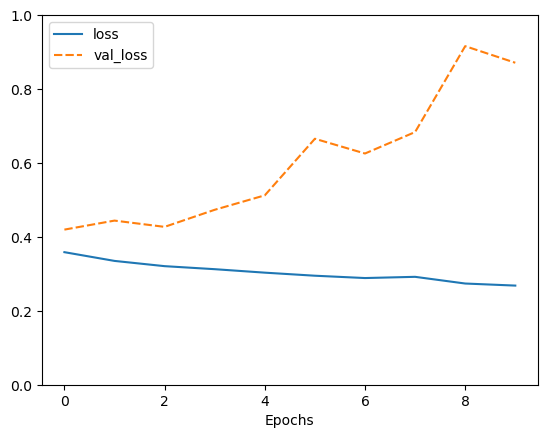

In [96]:
ax = sns.lineplot(history[['loss', 'val_loss']])
ax.set_xlabel("Epochs")
ax.set_ylim(0,1)

(0.0, 1.0)

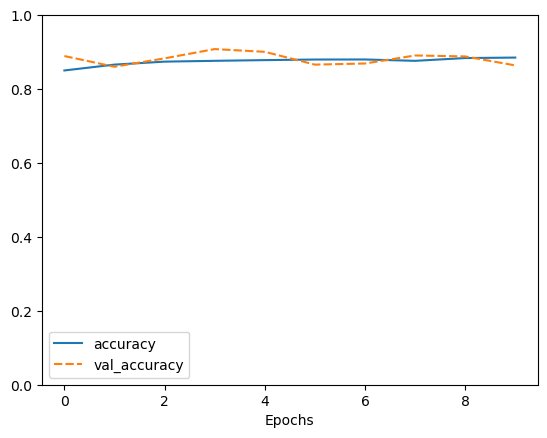

In [97]:
ax = sns.lineplot(history[['accuracy', 'val_accuracy']])
ax.set_xlabel("Epochs")
ax.set_ylim(0,1)

In [98]:
y_res = model(x_test)

In [99]:
def plot_preds(thresh):
    plt.gca().clear()
    plt.title(f"Predictions by threshold: {round(thresh,2)}")
    plt.plot(range(len(y_test)), y_test, label='True value')
    plt.plot(range(len(y_test)), y_res[:,1], ',', label='Prediction')
    # plt.plot(range(len(y_test)), y_res[:,1]>thresh, '.')
    plt.axhline(thresh, linewidth=0.25)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Sleeping')

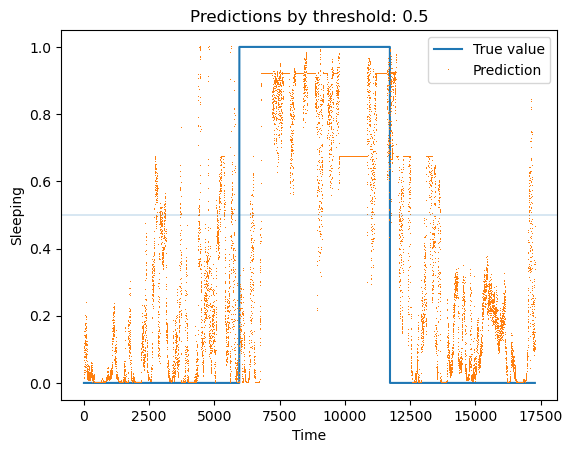

In [101]:
%matplotlib inline


fig, ax = plt.subplots()

plot_preds(0.5)
